In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
user_eng = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
user_eng['time_stamp'] = pd.to_datetime(user_eng['time_stamp'])

In [6]:
# determining whether there were at least 3 logins on seperate days in one seven day period for a user
adopted = {}
for x in user_eng.user_id.unique():
    # each id
    df = user_eng[user_eng['user_id']==x]
    df = pd.DataFrame(df.set_index('time_stamp').resample('D')['visited'].min().dropna())
    # condensing logins to one per day maximum
    if len(df) < 3:
        adopted[x] = 0
        pass
    # if df < 3 than 3 seperate logins in a 7 day period cannot happen
    freq = []
    freq.append(df.resample('W-MON')['visited'].sum().max())
    freq.append(df.resample('W-TUE')['visited'].sum().max())
    freq.append(df.resample('W-WED')['visited'].sum().max())
    freq.append(df.resample('W-THU')['visited'].sum().max())
    freq.append(df.resample('W-FRI')['visited'].sum().max())
    freq.append(df.resample('W-SAT')['visited'].sum().max())
    freq.append(df.resample('W-SUN')['visited'].sum().max())
    freq.sort()
    # checking all possible 7 day combinations
    if freq[-1] < 3:
        adopted[x] = 0
        # if the greatest freq is less than 3, then not an adopted user
    else:
        adopted[x] = 1

In [7]:
users['adopted'] = users['object_id'].map(adopted)
# creating adopted column in users

In [8]:
users = users.join(pd.get_dummies(users['creation_source']))
users.drop('creation_source', axis=1, inplace=True)
# dummy columns for creation source

In [9]:
users['invited'] = [0 if np.isnan(x) else 1 for x in users['invited_by_user_id']]
# whether a user was invited by another user or not

In [10]:
def invites(x):
    return len(users[users['invited_by_user_id']==x])

users['invites'] = users['object_id'].apply(invites)
# how many other users a user invited

In [11]:
users = users[users['adopted'].isnull()==False]
# we cannot use rows where there is no adopted value

In [12]:
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [13]:
users.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,invited,invites
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,1,0,11,10803.0,0.0,1,0,0,0,0,1,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,0,0,1,316.0,1.0,0,1,0,0,0,1,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,0,0,94,1525.0,0.0,0,1,0,0,0,1,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,0,0,1,5151.0,0.0,1,0,0,0,0,1,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,0,0,193,5240.0,0.0,1,0,0,0,0,1,0


In [14]:
users.adopted.mean()

0.18157089425365522

Only 18% of users are considered adopted users, so accuracy is not a good indicator of a strong model. We will use the roc_auc score to measure the success of our model. The roc_auc score will give us the area under the roc curve, which is a curve displaying the trade off of True Positives to False Positives.

# Model

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

In [16]:
# splitting the data into training and testing data randomly
y = users['adopted']
X = users.drop(['adopted','object_id','creation_time','name','email','org_id','last_session_creation_time','invited_by_user_id'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [17]:
n_params = [{'penalty':['l1','l2'], 'C':[.001,.01,.1,1,10]}]

lrgs = GridSearchCV(LogisticRegression(class_weight='balanced'), n_params, cv=10, scoring='roc_auc').fit(X_train, y_train)

print('LR GridSearchCV Best Score: ', lrgs.best_score_, ' with ' , lrgs.best_params_ )

print('LR Test Score: ', roc_auc_score(y_test, lrgs.predict(X_test))) 
print('LR Train Score: ', roc_auc_score(y_train, lrgs.predict(X_train)))

LR GridSearchCV Best Score:  0.554630173161  with  {'C': 0.001, 'penalty': 'l2'}
LR Test Score:  0.564526884443
LR Train Score:  0.540882260754


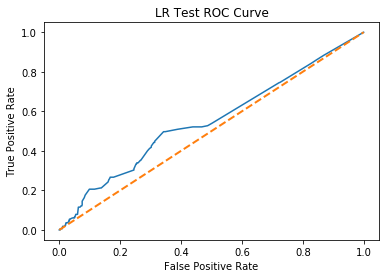

In [18]:
fpr, tpr, _ = roc_curve(y_test, lrgs.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], '--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR Test ROC Curve')
plt.show()

In [19]:
lr = LogisticRegression(class_weight= 'balanced', C=.001, penalty='l2').fit(X_train,y_train)
coef = list(zip(lr.coef_[0], X_train.columns))
coef

[(0.020434071267538895, 'opted_in_to_mailing_list'),
 (0.005419741668159549, 'enabled_for_marketing_drip'),
 (0.06530697197551133, 'GUEST_INVITE'),
 (-0.037850266490459521, 'ORG_INVITE'),
 (0.025184048725424877, 'PERSONAL_PROJECTS'),
 (-0.05918392668979984, 'SIGNUP'),
 (-0.022470397380065083, 'SIGNUP_GOOGLE_AUTH'),
 (0.027456705485051448, 'invited'),
 (0.061619758964865677, 'invites')]

This model is slightly above random chance at predicting whether a user will become adopted (.5 would represent random chance). By looking at the coefficients by feature we can see what the model thought predicts whether a user will become an adopted user. Being invited to an organization as a guest, the number of guests that a user has invited, and signing up via the website are the most distinguishing features of whether a user will become adopted or not according to this model. 

I considered a random forest model, but then the results would not be so easily interpretable. f1 score (the harmonic mean of precision and recall) could also have been a good measure of model performance. Using the difference between last login time and time of creation was considered, but ultimately that feature was determined to be relatively useless in trying to predict future user adoption. There were too many different organizations with too few members to be useful. More details on the organization types could have been useful. 